In [1]:
import os
import numpy as np
import pandas as pd
from datetime import date, datetime, timedelta
from tqdm import tqdm
import pickle
import json

import requests
from urllib.error import HTTPError
import urllib.request
from bs4 import BeautifulSoup

from basketball_reference_web_scraper import client
from xgboost import XGBRegressor

import warnings
warnings.filterwarnings('ignore')

#pandas show all columns
pd.set_option('display.max_columns', None)

In [2]:
#load team to abbreviation mapping
with open(os.path.dirname(os.getcwd()) + '/scripts' + '/team_to_abbreviations.json') as f:
      team_to_abbreviations = json.load(f)

In [3]:
filter_advanced = [
        'name',
        'player_efficiency_rating',
         'true_shooting_percentage',
         'three_point_attempt_rate',
         'free_throw_attempt_rate',
         'offensive_rebound_percentage',
         'defensive_rebound_percentage',
         'total_rebound_percentage',
         'assist_percentage',
         'steal_percentage',
         'block_percentage',
         'turnover_percentage',
         'usage_percentage',
         'offensive_win_shares',
         'defensive_win_shares',
         'win_shares',
         'win_shares_per_48_minutes',
         'offensive_box_plus_minus',
         'defensive_box_plus_minus',
         'box_plus_minus',
         'value_over_replacement_player'
    ]

def extract_advanced_stats(year):
    advanced_stats_df = pd.DataFrame(client.players_advanced_season_totals(season_end_year=year))
    advanced_stats_df['year'] = year
    
    advanced_stats_df = advanced_stats_df[filter_advanced]
    advanced_stats_df = advanced_stats_df.rename(columns={'name':'Player'})
    return advanced_stats_df

In [4]:
year = 2022
basic_stats_df = pd.DataFrame(client.players_season_totals(season_end_year=year))

advanced_stats_df = pd.DataFrame(client.players_advanced_season_totals(season_end_year=year))
advanced_stats_df = advanced_stats_df[filter_advanced]
advanced_stats_df = advanced_stats_df.rename(columns={'name':'Player'})

In [5]:
filter_basic = [
    'name',
    'games_played',
    'team',
    'points',
    'assists',
    'offensive_rebounds',
    'defensive_rebounds',
    'steals',
    'blocks',
    'made_field_goals',
    'attempted_field_goals',
    'made_three_point_field_goals',
    'attempted_three_point_field_goals'
]
basic_stats_df = basic_stats_df[filter_basic]
basic_stats_df = basic_stats_df.rename(columns={'name':'Player',
                               'points':'PTS',
                               'assists':'AST',
                               'steals':'STL',
                               'blocks':'BLK',})

basic_stats_df['PTS'] = basic_stats_df['PTS'] / basic_stats_df['games_played']
basic_stats_df['AST'] = basic_stats_df['AST'] / basic_stats_df['games_played']
basic_stats_df['STL'] = basic_stats_df['STL'] / basic_stats_df['games_played']
basic_stats_df['BLK'] = basic_stats_df['BLK'] / basic_stats_df['games_played']
basic_stats_df['FG%'] = basic_stats_df['made_field_goals'] / basic_stats_df['attempted_field_goals']
basic_stats_df['3P%'] = basic_stats_df['made_three_point_field_goals'] / basic_stats_df['attempted_three_point_field_goals']
basic_stats_df['TRB'] = (basic_stats_df['offensive_rebounds'] + basic_stats_df['defensive_rebounds']) / basic_stats_df['games_played']

basic_stats_df = basic_stats_df[['Player', 'games_played', 'team', 'PTS', 'AST', 'STL', 'BLK', 'FG%' ,'3P%' , 'TRB']]
basic_stats_df['team'] = basic_stats_df['team'].astype(str).str.slice(5,)
basic_stats_df['team'] = basic_stats_df['team'].astype(str).str.replace('_', ' ').str.lower()

In [6]:
def extract_team_stats_new(year):
    url = f"https://www.basketball-reference.com/leagues/NBA_{year}_standings.html#all_confs_standings_E%22"

    #east
    team_east_standing_table = pd.read_html(url)[0]
    team_east_standing_table = team_east_standing_table.rename({'Eastern Conference': 'team'}, axis=1)
    #remove 'Division' in team column (e.g. Atlantic Division)
    team_east_standing_table = team_east_standing_table[team_east_standing_table['team'].str.contains('Division')==False]
    new_east = team_east_standing_table["team"].str.split("(", n = 1, expand = True)
    team_east_standing_table["team"] = [i[:-1] for i in new_east[0]]
    team_east_standing_table["seed"] = [i[:-1] for i in new_east[1]]

    #west
    team_west_standing_table = pd.read_html(url)[1]
    team_west_standing_table = team_west_standing_table.rename({'Western Conference': 'team'}, axis=1)
    #remove 'Division' in team column (e.g. Atlantic Division)
    team_west_standing_table = team_west_standing_table[team_west_standing_table['team'].str.contains('Division')==False]
    new_west = team_west_standing_table["team"].str.split("(", n = 1, expand = True)
    team_west_standing_table["team"] = [i[:-1] for i in new_west[0]]
    team_west_standing_table["seed"] = [i[:-1] for i in new_west[1]]

    #combine east and west 
    team_standing_table = pd.concat([team_east_standing_table, team_west_standing_table])
    
    #remove * in team column
    team_standing_table.team = team_standing_table.team.str.replace('*', '')
        
    #map abbreviation to full team name
    team_standing_table['Tm'] = team_standing_table['team'].map(team_to_abbreviations)
    
    #filter only needed columns
    team_standing_table_sub = team_standing_table[['Tm', 'team', 'W', 'W/L%', 'seed']]
    
    return team_standing_table_sub

In [7]:
#left merge mvp candidate with team standings table on team abbreviation
team_standing_table_sub = extract_team_stats_new(2022)
team_standing_table_sub['team'] = team_standing_table_sub['team'].str.lower()
joined_table_2022 = pd.merge(basic_stats_df, team_standing_table_sub, how='left', on='team')
joined_table_2022 = pd.merge(joined_table_2022, advanced_stats_df, how='left', on='Player')

joined_table_2022.loc[joined_table_2022['Player'] == 'Nikola Jokić', 'Player'] = 'Nikola Jokic'

In [8]:
#### 

In [9]:
to_drop = [
    'Rank',
    'Player',
    'Age',
    'year',
    'Tm',
    'team',
    'First',
    'Pts Won',
    'Pts Max',
    'WS/48',
    'WS',
    'MP',
    'G',
    'W', 
    'FG%',
    '3P%',
    'STL', 
    'BLK',
    'three_point_attempt_rate',
    'total_rebound_percentage',
    'offensive_rebound_percentage',
    'block_percentage',
    'defensive_rebound_percentage',
    'steal_percentage',
    'turnover_percentage',
    'assist_percentage',
    'AST',
    'TRB',
    'FT%',
    'win_shares', 
    'box_plus_minus', 
    'defensive_box_plus_minus',
    'offensive_win_shares', 
    'defensive_win_shares', 
    'true_shooting_percentage' 
]

In [10]:
def extract_mvp_ladder(date):
    date_str = date.strftime(format='%m-%d-%Y')
    date_str_split = date_str.split('-')
    
    date_map = {
        '01': 'jan',
        '02': 'feb',
        '03': 'mar',
        '04': 'apr',
        '05': 'may',
        '06': 'jun',
        '07': 'jul',
        '08': 'aug',
        '09': 'sep',
        '10': 'oct',
        '11': 'nov',
        '12': 'dec'
    }
    
    month = date_map[date_str_split[0]]
    day = date_str_split[1]
    year = date_str_split[2]
    
    #2022 candidate table
    url = f'https://www.nba.com/news/kia-mvp-ladder-{month}-{day}-{year}-edition'
    try: 
        html = requests.get(url).content

        soup = BeautifulSoup(html)
        remove_line = 'Last week’s ranking'
        remove_line2 = 'ET'
        remove_line3 = 'The Next Five'

        top_five = []
        next_five_pre = [] 

        ######### TOP 5 extract #######
        method_1_lst = []
        for line in soup.find_all("h3")[1:-1]:
            if remove_line not in str(line):
                name_raw = str(line).split(',')[0]
                name_raw = name_raw.split('.')[1]
                name = name_raw[1:]
                method_1_lst.append(name)

        method_2_lst = []
        for line in soup.find_all("strong")[1:-1]:
            if remove_line not in str(line):
                if remove_line2 not in str(line):
                    if remove_line3 not in str(line):
                        name_raw = str(line).split(',')[0]
                        name_raw = name_raw.split('.')[1]
                        name = name_raw[1:]
                        method_2_lst.append(name)

        top_five = method_1_lst
        for i in method_2_lst:
            if i not in top_five:
                top_five.append(i)
        top_five = [i for i in top_five if i != '/strong>']

        ######### NEXT 5 extract #######
        
        for line in soup.find_all("p"):
            if 'week: ' in str(line):
                name_raw = str(line).split(',')[0]
                name_raw = name_raw.split('.')[1]
                name = name_raw[1:]
                #name = name.split('>')[1][1:]
                next_five_pre.append(name)
        next_five = [] 
        for name in next_five_pre:
            if '/strong>' in name:
                name = name.split('>')[1][1:]
                next_five.append(name)
            else:
                next_five.append(name)

        top_ten = top_five + next_five
        return top_ten
    except HTTPError as err:
        print(f'no mvp race has been found for this date yet: {date}')

In [11]:
#ONLY ADDS INFO FOR DATE THAT IS NOT IN DICT YET
def compile_ladder_dict(mvp_ladder_by_date, datetime_lst, joined_table_2022):

    for date in datetime_lst:
        if date not in list(mvp_ladder_by_date.keys()):
            top_ten = extract_mvp_ladder(date=date)
            date_str = date.strftime(format='%m-%d-%Y')
            print(f'extracting top 10 for {date_str}')

            #left merge mvp candidate with team standings table on team abbreviation
            team_standing_table_sub = extract_team_stats_new(2022)
            team_standing_table_sub['team'] = team_standing_table_sub['team'].str.lower()
            joined_table_2022 = pd.merge(basic_stats_df, team_standing_table_sub, how='left', on='team')
            joined_table_2022 = pd.merge(joined_table_2022, advanced_stats_df, how='left', on='Player')
            joined_table_2022.loc[joined_table_2022['Player'] == 'Nikola Jokić', 'Player'] = 'Nikola Jokic'
            
            joined_table_2022 = joined_table_2022[joined_table_2022['Player'].isin(top_ten)]
            # adjust VORP at the current pace and project to rest of the season
            joined_table_2022_sub = joined_table_2022[['Player', 'games_played', 'value_over_replacement_player']]
            joined_table_2022_sub['games'] = 82
            joined_table_2022_sub['games_left'] = (joined_table_2022_sub['games'] - joined_table_2022_sub['games_played'])
            joined_table_2022_sub['vorp/games_played'] = (joined_table_2022_sub['value_over_replacement_player'] / joined_table_2022_sub['games_played'])
            joined_table_2022_sub['adjusted_vorp'] = (joined_table_2022_sub['vorp/games_played'] * joined_table_2022_sub['games_left']) + joined_table_2022_sub['value_over_replacement_player']
            joined_table_2022['value_over_replacement_player'] = joined_table_2022_sub['adjusted_vorp']

            mvp_ladder_by_date[date_str] = {'ladder': top_ten, 'stats': joined_table_2022.to_json()}
        return mvp_ladder_by_date

In [12]:
def prep_train_test(df, forecast_df):
    #train; using hitorical data from 1980 - 2021
    forecast_X_train_df = df.copy()
    forecast_X_train_df.drop(to_drop, axis=1, inplace=True)
    forecast_y_train_df = forecast_X_train_df['Share']
    forecast_X_train_df.drop(['Share'], axis=1, inplace=True)
    
    #data to be forecasted: 2022 mvp candidates from NBA's MVP ladder
    xgb_cols = ['PTS', 'W/L%', 'seed', 'player_efficiency_rating', 'free_throw_attempt_rate', 'usage_percentage', 'win_shares_per_48_minutes', 'offensive_box_plus_minus', 'value_over_replacement_player']
    data_2022_cleaned = forecast_df.copy()
    data_2022_cleaned = data_2022_cleaned[list(xgb_cols)]
    forecast_X_test_df = data_2022_cleaned
    
    #print(f'Training dataset columns: \n{list(forecast_X_train_df.columns)} \n')
    #print(f'Forecasting dataset columns: \n{list(forecast_X_test_df.columns)}')
    return forecast_X_train_df, forecast_y_train_df, forecast_X_test_df

In [13]:
def fit_forecast_model(regressor, data_2022):
    model = regressor
    model.fit(forecast_X_train_df, forecast_y_train_df) 
    predictions = model.predict(forecast_X_test_df)
    
    mvp_race_forecast = data_2022.copy()
    mvp_race_forecast['Share Prediction'] = predictions
    mvp_race_forecast = mvp_race_forecast.sort_values(["Share Prediction"], ascending = (False))
    
    mvp_race_forecast_sub = mvp_race_forecast[[
                                                'Player',
                                                'Share Prediction',
                                                'PTS',
                                               'value_over_replacement_player',
                                               'seed',
                                                'W/L%',
                                               'player_efficiency_rating',
                                               'win_shares_per_48_minutes',
                                                'offensive_box_plus_minus',
                                                'usage_percentage',
                                            'free_throw_attempt_rate'
                                              ]].reset_index(drop=True)
    mvp_race_forecast_sub.head()
    return model, mvp_race_forecast_sub

In [14]:
def js_r(filename: str):
    with open(filename) as f_in:
        return json.load(f_in)

mvp_ladder_by_date = js_r('mvp_ladder_data.json')

In [39]:
#DATE TO START
datetime_object = datetime.strptime('Jan 14 2022', '%b %d %Y')

datetime_object_next = datetime_object
datetime_lst = [datetime_object_next]

for i in range(12):
    datetime_object_next = datetime_object_next + timedelta(days=7)
    if datetime_object_next <= datetime.today():
        datetime_lst.append(datetime_object_next)
datetime_lst

[datetime.datetime(2022, 1, 14, 0, 0), datetime.datetime(2022, 1, 21, 0, 0)]

In [40]:
mvp_ladder_by_date = compile_ladder_dict(mvp_ladder_by_date=mvp_ladder_by_date,
                    datetime_lst=datetime_lst,
                    joined_table_2022=joined_table_2022)

extracting top 10 for 01-14-2022


In [41]:
## PYTHON
#from pathlib import Path
#data_path = Path(__file__).parents[1] / 'data/master_table.csv'

## JUPYTER
data_path = os.path.dirname(os.getcwd()) + '/data' + '/master_table.csv'
master_table = pd.read_csv(data_path)

In [45]:
#forecast_over_time = pd.DataFrame(columns=['date', 'Player', 'Share Prediction'])
forecast_over_time = pd.DataFrame(columns=
                                  ['date',
                                      'Player',
                                     'Share Prediction',
                                     'PTS',
                                     'value_over_replacement_player',
                                     'seed',
                                     'W/L%',
                                     'player_efficiency_rating',
                                     'win_shares_per_48_minutes',
                                     'offensive_box_plus_minus',
                                     'usage_percentage',
                                     'free_throw_attempt_rate'])

for date in datetime_lst:
    date_str = date.strftime(format='%m-%d-%Y')
    stats_df = pd.read_json(mvp_ladder_by_date[date_str]['stats'])
    #train on historical data, predict on 2022 data
    forecast_X_train_df, forecast_y_train_df, forecast_X_test_df = prep_train_test(df=master_table, forecast_df=stats_df)
    
    xgb_model, xgb_summary = fit_forecast_model(regressor = XGBRegressor(
                                            n_estimators=16,
                                            max_depth=5,
                                            learning_rate=0.2745),
                   data_2022 = stats_df)
    
    xgb_summary = xgb_summary.head()
    #xgb_summary = xgb_summary[['Player', 'Share Prediction']]
    xgb_summary['date'] = date_str
    forecast_over_time = forecast_over_time.append(xgb_summary)

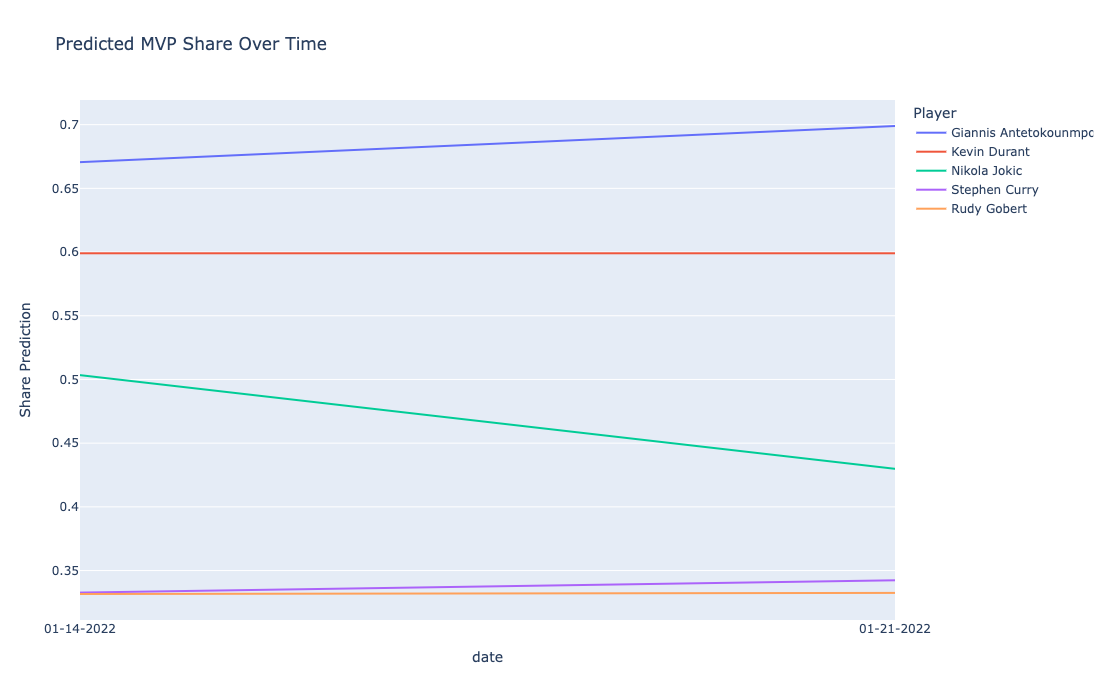

In [46]:
import plotly.express as px

fig = px.line(
    data_frame = forecast_over_time,
    x = 'date',
    y = 'Share Prediction',
    color= 'Player',
    hover_data= {
        'date':True,
        'Player':True,
        'Share Prediction':True,
        'seed':True,
        'W/L%':True,
    },
    title = 'Predicted MVP Share Over Time')

fig.update_layout(
    autosize=False,
    width=1000,
    height=700,)

fig.show()

In [48]:
with open("mvp_ladder_data.json", "w") as outfile:
    json.dump(mvp_ladder_by_date, outfile)

In [ ]:
################## UNDER THE HOOD ##################

In [49]:
## try 01-21-2022
stats_df = pd.read_json(mvp_ladder_by_date['01-21-2022']['stats'])
#train on historical data, predict on 2022 data
forecast_X_train_df, forecast_y_train_df, forecast_X_test_df = prep_train_test(df=master_table, forecast_df=stats_df)

xgb_model, xgb_summary = fit_forecast_model(regressor = XGBRegressor(
                                        n_estimators=16,
                                        max_depth=5,
                                        learning_rate=0.2745),
               data_2022 = stats_df)

In [50]:
xgb_summary

,Player,Share Prediction,PTS,value_over_replacement_player,seed,W/L%,player_efficiency_rating,win_shares_per_48_minutes,offensive_box_plus_minus,usage_percentage,free_throw_attempt_rate
0,Giannis Antetokounmpo,0.698939,28.578947,8.415789,4,0.604,31.1,0.276,6.8,35.2,0.578
1,Kevin Durant,0.599032,29.250000,7.061111,1,0.644,26.1,0.215,6.6,31.2,0.350
2,Nikola Jokic,0.429850,25.921053,10.789474,6,0.523,32.9,0.291,9.3,32.1,0.303
3,Stephen Curry,0.342355,26.365854,6.400000,2,0.717,22.0,0.191,6.1,32.0,0.239
4,Rudy Gobert,0.332459,15.850000,4.920000,4,0.652,25.5,0.277,3.2,16.9,0.863
5,Joel Embiid,0.228048,28.030303,7.206061,6,0.578,30.7,0.254,6.7,35.6,0.594
6,Ja Morant,0.171785,24.676471,5.305882,3,0.667,24.5,0.175,5.9,31.7,0.329
7,LeBron James,0.135741,28.848485,7.951515,7,0.500,27.0,0.207,7.1,31.0,0.284
8,Chris Paul,0.112030,14.022727,4.659091,1,0.795,20.5,0.214,2.6,19.5,0.260
9,DeMar DeRozan,0.076271,25.725000,2.665000,2,0.636,22.4,0.157,2.9,31.2,0.393


In [51]:
## try 01-14-2022
stats_df = pd.read_json(mvp_ladder_by_date['01-14-2022']['stats'])
#train on historical data, predict on 2022 data
forecast_X_train_df, forecast_y_train_df, forecast_X_test_df = prep_train_test(df=master_table, forecast_df=stats_df)

xgb_model, xgb_summary = fit_forecast_model(regressor = XGBRegressor(
                                        n_estimators=16,
                                        max_depth=5,
                                        learning_rate=0.2745),
               data_2022 = stats_df)

In [52]:
xgb_summary

,Player,Share Prediction,PTS,value_over_replacement_player,seed,W/L%,player_efficiency_rating,win_shares_per_48_minutes,offensive_box_plus_minus,usage_percentage,free_throw_attempt_rate
0,Giannis Antetokounmpo,0.670559,28.615385,8.410256,4,0.604,30.9,0.273,6.7,35.2,0.576
1,Kevin Durant,0.599032,29.250000,7.061111,1,0.644,26.2,0.215,6.7,31.2,0.350
2,Nikola Jokic,0.503389,25.923077,10.933333,6,0.523,33.0,0.295,9.5,31.6,0.300
3,Stephen Curry,0.332704,26.261905,6.247619,2,0.717,21.9,0.190,5.9,31.9,0.242
4,Rudy Gobert,0.331596,16.048780,5.000000,4,0.652,25.7,0.280,3.3,17.1,0.868
5,Joel Embiid,0.228048,28.382353,7.235294,6,0.578,30.9,0.256,7.0,35.8,0.587
6,Ja Morant,0.202879,25.057143,5.388571,3,0.667,24.8,0.176,6.0,31.9,0.328
7,LeBron James,0.137129,28.852941,7.717647,7,0.500,26.8,0.204,6.9,31.1,0.279
8,Chris Paul,0.112030,14.022727,4.659091,1,0.795,20.5,0.214,2.6,19.5,0.260
9,DeMar DeRozan,0.076271,25.951220,3.000000,2,0.636,22.7,0.163,3.1,31.2,0.407
